<a href="https://colab.research.google.com/github/Aerospace87/ML-projects/blob/main/tensorflow/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import yfinance as yf

In [35]:
code_dict = {
    "Caterpillar Inc.": "CAT",
    "CNH Industrial N.V.": "CNH",
    "GE Aerospace" :"GE"
}

cat = yf.Ticker(code_dict["GE Aerospace"])

In [36]:
# get historical market data
hist = cat.history(period="max")

In [37]:
hist.drop(columns=["Volume", "Stock Splits", "Dividends"], inplace=True)

<Axes: xlabel='Date'>

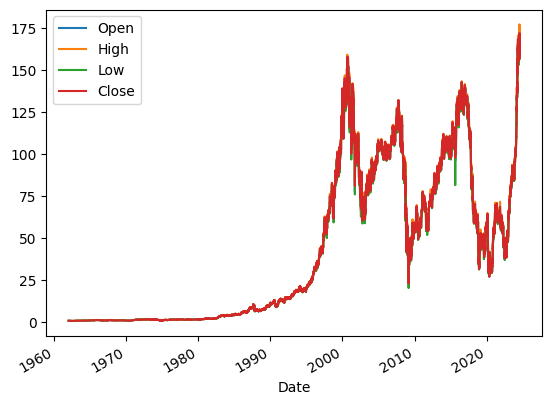

In [38]:
hist.reset_index().plot(x="Date",y=hist.columns)

In [39]:
hist.describe()

,Open,High,Low,Close
count,15749.000000,15749.000000,15749.000000,15749.000000
mean,41.192472,41.630597,40.733393,41.188287
std,44.881839,45.332534,44.419423,44.886000
min,0.469600,0.477004,0.459024,0.469600
25%,1.399637,1.409739,1.388530,1.399637
50%,17.362539,17.480655,17.173567,17.386168
75%,78.996973,79.908936,78.144118,79.072968
max,171.500000,177.199997,167.815951,172.000000


## Moving Average

In [70]:
import numpy as np
import pandas as pd

def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
     This implementation is *much* faster than the previous one"""
  mov = np.cumsum(series)

  # This is necessary because to subtract two pandas series it is necessary
  # That both series have the same index. Therefore we force the series
  # mov[window_size:] and mov[:-window_size] to have the same index

  index = pd.Index(
      list(
          range(mov.size - window_size)
      )
  )

  mov[window_size:] = mov[window_size:].set_axis(index)- mov[:-window_size].set_axis(index)

  return mov[window_size - 1:-1] / window_size

In [81]:
window_size = 200

for col in hist.columns:
  mov_average_col = col + "_mov_avg"
  hist[mov_average_col] = moving_average_forecast(hist[col], window_size)

<Axes: xlabel='Date'>

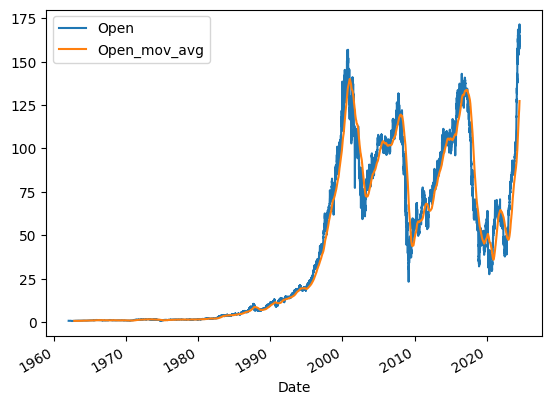

In [82]:
hist.reset_index().plot(x="Date", y= ["Open", "Open_mov_avg"])